In [66]:
#import pyart
from matplotlib import pyplot as plt
from __future__ import print_function
import gdal
import osr
import numpy as np
from mpl_toolkits.basemap import Basemap
import pickle
#warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
#NEEDS SPECIAL ENV! 
#conda create -n gdal_test -c conda-forge python=3.5 basemap gdal

In [ ]:
#http://stackoverflow.com/questions/20488765/plot-gdal-raster-using-matplotlib-basemap

In [3]:
def convertXY(xy_source, inproj, outproj):
    # function to convert coordinates

    shape = xy_source[0,:,:].shape
    size = xy_source[0,:,:].size

    # the ct object takes and returns pairs of x,y, not 2d grids
    # so the the grid needs to be reshaped (flattened) and back.
    ct = osr.CoordinateTransformation(inproj, outproj)
    xy_target = np.array(ct.TransformPoints(xy_source.reshape(2, size).T))

    xx = xy_target[:,0].reshape(shape)
    yy = xy_target[:,1].reshape(shape)

    return xx, yy

In [53]:
ds = gdal.Open("/Users/scollis/Downloads/ena_shapefiles/dtm_gra.tif")

data = ds.ReadAsArray()
gt = ds.GetGeoTransform()
proj = ds.GetProjection()

xres = gt[1]
yres = gt[5]

# get the edge coordinates and add half the resolution 
# to go to center coordinates
xmin = gt[0] + xres * 0.5
xmax = gt[0] + (xres * ds.RasterXSize) - xres * 0.5
ymin = gt[3] + (yres * ds.RasterYSize) + yres * 0.5
ymax = gt[3] - yres * 0.5

ds = None

# create a grid of xy coordinates in the original projection
xy_source = np.mgrid[xmin:xmax+xres:xres, ymax+yres:ymin:yres]

In [49]:
print(xy_source.shape)
#xy_source[0] = xy_source[0] * -1.0

(2, 1073, 990)


In [50]:
#39.0525° N, 28.0069° W

In [54]:
#llcrnrlon=-27.9
llcrnrlat=39
#urcrnrlon=-28.1
urcrnrlon=-27.9
llcrnrlon=-28.1
urcrnrlat=39.1
lats = np.arange(llcrnrlat, urcrnrlat, .02)
lons = np.arange(llcrnrlon, urcrnrlon, .02)

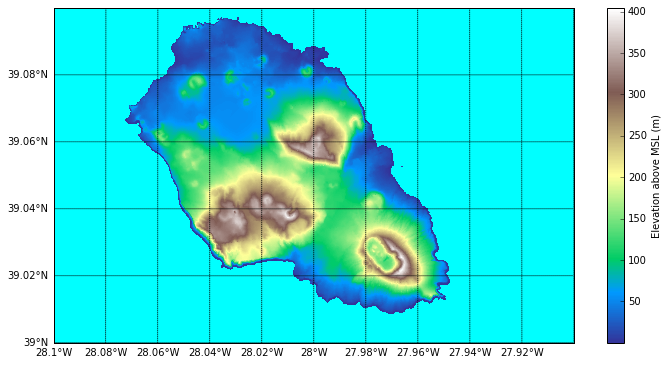

In [63]:
# Create the figure and basemap object
fig = plt.figure(figsize=(12, 6))
m = Basemap(projection='lcc', lon_0=-28, lat_0=39, resolution='c', 
           llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat,
            urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat)

# Create the projection objects for the convertion
# original (Albers)
inproj = osr.SpatialReference()
inproj.ImportFromWkt(proj)

# Get the target projection from the basemap object
outproj = osr.SpatialReference()
outproj.ImportFromProj4(m.proj4string)

# Convert from source projection to basemap projection
xx, yy = convertXY(xy_source, inproj, outproj)

elev = data.T
the_sea = data.T < 0.1
masked_data = np.ma.masked_where(the_sea, elev)


# plot the data (first layer)
im1 = m.pcolormesh(xx, yy, 
                   masked_data, cmap=plt.cm.terrain)
plt.colorbar(label = 'Elevation above MSL (m)')
# labels = [left,right,top,bottom]
m.drawparallels(lats,labels=[True,False,False,False])
m.drawmeridians(lons,labels=[False,False,False,True])
# annotate
m.drawcountries()
m.drawcoastlines(linewidth=.5)
plt.gca().set_axis_bgcolor('aqua')

In [64]:
print(proj)
lonpt, latpt = m(xx,yy,inverse=True)

PROJCS["WGS 84 / UTM zone 26N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-27],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32626"]]


In [78]:
fh = open('/data/ena_terrain.pickle', 'wb')
pickle.dump({'numpy_dem' : masked_data,
            'proj' : proj,
            'xy_source' : xy_source,
            'lat' : latpt,
            'lon' : lonpt}, fh)
fh.close()

In [70]:
pickle.dump?

In [72]:
outproj


<osgeo.osr.SpatialReference; proxy of <Swig Object of type 'OSRSpatialReferenceShadow *' at 0x12d8bc7e0> >

In [73]:
lonpt, latpt = m(xx,yy,inverse=True)

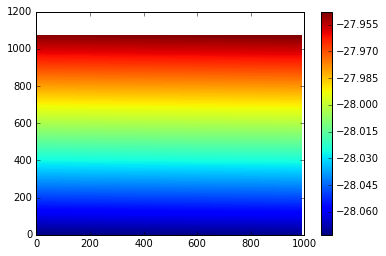

In [76]:
plt.pcolormesh(lonpt)
plt.colorbar()